In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import pylab
import itertools
import matplotlib as mpl
from scipy import linalg

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('data/Test_data_07_11_2015.csv',sep=',')

In [3]:
X = df[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]

In [4]:
r = X.rolling(60).mean()


In [5]:
data_smooth = pd.DataFrame(r.iloc[59:,:])
data_smooth.shape

(76071, 9)

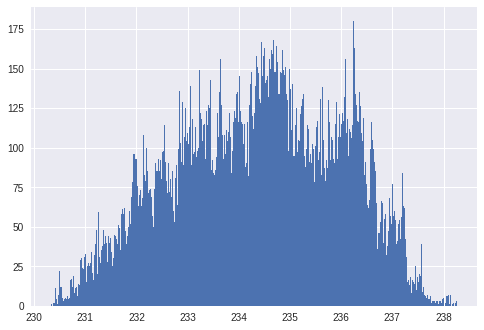

In [6]:
plt.hist(data_smooth.iloc[:,0],bins=1000)
plt.show()

# PCA Based Anomaly Detection 

In [7]:
X_std = StandardScaler().fit_transform(data_smooth)

In [8]:
sklearn_pca = PCA(n_components=9)
Y_sklearn = sklearn_pca.fit_transform(X_std)

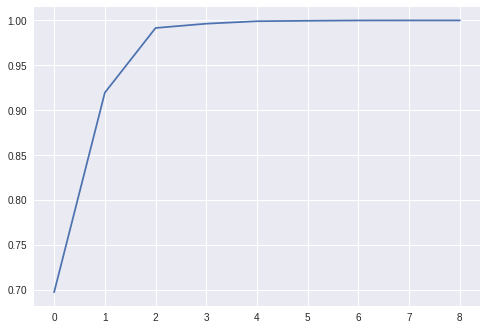

In [9]:
plt.plot(sklearn_pca.explained_variance_ratio_.cumsum())

# Method to calculate the PCA which captures very less variance

In [10]:
class PCA_decomp:
    def __init__(self):
        self.e_values = None
        self.e_vectors = None
        self.mean_data = None

    # Find all eigenvalues and eigenvectors
    # data -> instances as rows
    def prepare(self, data):
        # Substract mean
        self.mean_data = np.mean(data, axis=0)
        adj_data = data - self.mean_data
        # Covariance matrix
        covariance = np.cov(adj_data.T)
        # Eigenstuff
        self.e_values, self.e_vectors = np.linalg.eig(covariance)
        i = np.argsort(self.e_values)
        i = i[::-1]
        self.e_vectors = self.e_vectors[:,i]
        self.e_values = self.e_values[i]
        # Print the coverage of variance
        table = pd.DataFrame(index=['eVal','eTotal', 'Idiv%', '%'], columns=list(range(len(self.e_values))))
        current_val = 0
        total_val = np.sum(self.e_values)
        for i, val in enumerate(self.e_values):
            current_val += val
            table[i] = [val, current_val, val/total_val, current_val/total_val]
        print('Coverage of Variance:')
        print(table)
        print("\n")
        return table

    # Project the data into the normal or abnormal subspace
    def project(self, data, dimensions, normal_subspace=True):
        adj_data = data - self.mean_data
        if normal_subspace:
            # Extract only the top most eigenvectors
            e_vectors = self.e_vectors[:,:dimensions]
        else:
            # Extract the smallers eigenvectors as the anomalous part
            e_vectors = self.e_vectors[:,dimensions:]
        # Return the projected data
        return np.dot(adj_data, e_vectors)

    def revert(self, projected_data, dimensions):
        e_vectors = self.e_vectors[:,:dimensions]
        return np.dot(projected_data, e_vectors.T) + self.mean_data

In [11]:
a = PCA_decomp()
df_pca = a.prepare(X_std)

Coverage of Variance:
               0         1         2         3         4         5         6  \
eVal    6.276633  1.999516  0.648243  0.042887  0.024598  0.004565  0.003294   
eTotal  6.276633  8.276150  8.924393  8.967280  8.991878  8.996443  8.999737   
Idiv%   0.697395  0.222166  0.072026  0.004765  0.002733  0.000507  0.000366   
%       0.697395  0.919560  0.991586  0.996351  0.999084  0.999592  0.999958   

               7         8  
eVal    0.000350  0.000031  
eTotal  9.000087  9.000118  
Idiv%   0.000039  0.000003  
%       0.999997  1.000000  




Split the PCA components into normal and abnormal depending on the variance. The first 4 components capture most of the variances as can be seen from the *sklearn_pca.explained_variance_ratio_.cumsum()* plot and hence, will be considered as **normal** and rest as **abnormal**

In [12]:
df_pca_abnormal = a.project(X_std,6,normal_subspace=False)

In [13]:
df_pca_abnormal.shape

(76071, 3)

In [14]:
df_pca_abnormal[:5]

array([[-0.01689663, -0.00525643,  0.000244  ],
       [-0.01615253, -0.00506404,  0.00030335],
       [-0.01575099, -0.00458404,  0.00026311],
       [-0.01462793, -0.00425966,  0.00031854],
       [-0.01416099, -0.00393925,  0.00033001]])

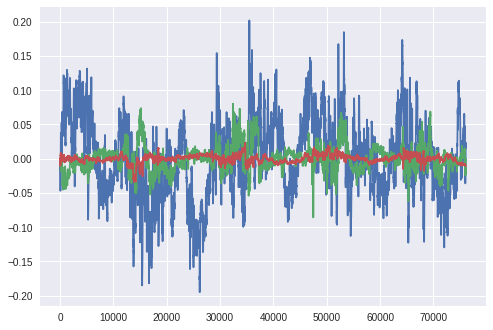

In [15]:
plt.plot(df_pca_abnormal)

# Calculate the Squared Prediction Error

$$ y = ŷ + ỹ $$



$$ŷ = PP^Ty = Cy$$ and $$ỹ = I − PP^T y = C̃y $$


$$ \textbf{SPE} ≡  \parallel ỹ \space \parallel ^ 2 $$

$$ \delta^2_\alpha == \phi_1 \Bigg[ \frac{c_\alpha\sqrt{2\phi_2 h^2_0}}{\phi_1} + 1 + \frac{ \phi_2 h_0(h_0 -1)}{\phi_1 ^ 2} \Bigg]^\frac{1}{h_0} $$

$$\phi_i=\sum_{j=r+1}^m \lambda^i_j \quad for \quad i = 1,2,3 $$

$$ h_0 = 1 - \frac{2\phi_1 \phi_3}{3\phi_2 ^2} $$

In [16]:
def calc_spe(data):
    norm_val = np.linalg.norm(data,axis=1)
    SPE = norm_val * norm_val
    return SPE

In [17]:
spe_err = calc_spe(df_pca_abnormal)
spe_err

array([ 0.00031319,  0.00028664,  0.00026918, ...,  0.00041384,
        0.00040005,  0.00037394])

In [18]:
spe_err.shape[0]

76071

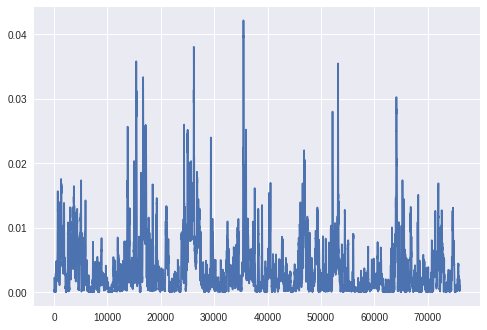

In [19]:
plt.plot(spe_err)

# Calculate the Q-threshold

Remember eigen values are in descending order

In [20]:
eig_vals = df_pca.iloc[0,:]
eig_vals# gives the eigen values of the residual PCA components

0    6.276633
1    1.999516
2    0.648243
3    0.042887
4    0.024598
5    0.004565
6    0.003294
7    0.000350
8    0.000031
Name: eVal, dtype: float64

$$\phi_i=\sum_{j=r+1}^m \lambda^i_j \quad for \quad i = 1,2,3 $$

In [21]:
list_eig = []
eig_vals_j = 0
for i in (1,2,3):
    for j in range(df_pca_abnormal.shape[1], data_smooth.shape[1]):
        print j
        eig_vals_j += eig_vals[j]
    list_eig.append(np.power(eig_vals_j,i))

3
4
5
6
7
8
3
4
5
6
7
8
3
4
5
6
7
8


In [22]:
list_eig

[0.075725351646408187, 0.022937315527888708, 0.011724319918174443]

In [23]:
phi_1,phi_2,phi_3 = list_eig[0],list_eig[1],list_eig[2]

In [24]:
phi_1

0.075725351646408187

$$ h_0 = 1 - \frac{2\phi_1 \phi_3}{3\phi_2 ^2} $$

In [25]:
h0 = 1 - ((2 * phi_1 * phi_3)/(3 * phi_2 * phi_2))

In [26]:
h0

-0.12499999999999978

$$ \delta^2_\alpha == \phi_1 \Bigg[ \frac{c_\alpha\sqrt{2\phi_2 h^2_0}}{\phi_1} + 1 + \frac{ \phi_2 h_0(h_0 -1)}{\phi_1 ^ 2} \Bigg]^\frac{1}{h_0} $$

In [27]:
a = 2.576
b = np.sqrt(2 * phi_2 * h0 * h0)
c = phi_1
d = phi_2 * h0 * (h0 - 1)
e1 = 1/h0
threshold = ( c * np.power( ((a * b)/c) + 1 + (d/(c * c)),e1) )

In [28]:
threshold

5.4086912647795319e-05

In [29]:
count = 0
for i in range(spe_err.shape[0]):
    if spe_err[i] > threshold:
        count = count + 1
print count

74438
